In [1]:
# IRT Fault Detection: Binary Classification with Custom Metrics and Clear Plots

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import io
import time

In [2]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 70

In [3]:
# --- Organize Dataset ---
original_data_dir = '/Users/reamy/Desktop/THESIS/MC_dataset copy 2'  # Contains 'patchwork' and 'block' folders
base_dir = 'data/processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [4]:
# Create directories
for split in ['train', 'val']:
    for cls in ['Block', 'PatchWork']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['Block', 'PatchWork']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))


In [5]:
# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 68 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [6]:
# --- Get True Labels for Callback ---
val_labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])

# --- Build Simple CNN Model ---
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001)
model.summary()

# Capture the model summary output
summary_output = io.StringIO()
model.summary(print_fn=lambda x: summary_output.write(x + "\n"))
summary_text = summary_output.getvalue()

# Save the summary to a text file
summary_file_path = os.path.join(os.getcwd(), 'model_summary.txt')
with open(summary_file_path, 'w') as f:
    f.write(summary_text)

print(f"Model summary saved to {summary_file_path}")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Model summary saved to /Users/reamy/Desktop/THESIS/SDCNN_MC/model_summary.txt


In [7]:

# --- Compile Model ---
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)

In [8]:
# --- Custom Callback to Track Metrics ---
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, val_labels):
        self.val_generator = val_generator
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_generator, val_labels)

In [9]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Save the best model only
checkpoint = ModelCheckpoint(
    filepath='best_SDCNN_BC_model.h5',          # file to save the best model
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # save only if it's the best so far
    mode='min',                        # because we want to minimize loss
    verbose=1                          # print when saving
)

In [10]:
# --- Training the Model ---
#start timer
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[metrics_callback,checkpoint, early_stop]
)
# End timer
end_time = time.time()
# Calculate and print elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4589 - auc: 0.5409 - loss: 0.6913 - precision: 0.4681 - recall: 0.65
Epoch 1: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 1: val_loss improved from inf to 0.64583, saving model to best_SDCNN_BC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - accuracy: 0.4619 - auc: 0.5522 - loss: 0.6914 - precision: 0.4711 - recall: 0.6654 - val_accuracy: 0.5000 - val_auc: 0.9753 - val_loss: 0.6458 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6127 - auc: 0.8456 - loss: 0.6073 - precision: 0.7194 - recall: 0.53
Epoch 2: Precision=0.6429, Recall=1.0000, F1 Score=0.7826

Epoch 2: val_loss improved from 0.64583 to 0.57432, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.6066 - auc: 0.8277 - loss: 0.6085 - precision: 0.6833 - recall: 0.5690 - val_accuracy: 0.7222 - val_auc: 0.9877 - val_loss: 0.5743 - val_precision: 0.6429 - val_recall: 1.0000
Epoch 3/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5737 - auc: 0.8357 - loss: 0.6272 - precision: 0.4816 - recall: 0.77
Epoch 3: Precision=1.0000, Recall=0.7778, F1 Score=0.8750

Epoch 3: val_loss improved from 0.57432 to 0.52044, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 608ms/step - accuracy: 0.5663 - auc: 0.7941 - loss: 0.6276 - precision: 0.4991 - recall: 0.6968 - val_accuracy: 0.8889 - val_auc: 0.9753 - val_loss: 0.5204 - val_precision: 1.0000 - val_recall: 0.7778
Epoch 4/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9041 - auc: 0.6539 - loss: 0.4631 - precision: 0.6667 - recall: 0.4657         
Epoch 4: Precision=1.0000, Recall=0.7778, F1 Score=0.8750

Epoch 4: val_loss improved from 0.52044 to 0.45920, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 858ms/step - accuracy: 0.8840 - auc: 0.7356 - loss: 0.4660 - precision: 0.7500 - recall: 0.5110 - val_accuracy: 0.8889 - val_auc: 0.9877 - val_loss: 0.4592 - val_precision: 1.0000 - val_recall: 0.7778
Epoch 5/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9608 - auc: 0.9942 - loss: 0.4236 - precision: 0.9365 - recall: 1.00
Epoch 5: Precision=0.7500, Recall=1.0000, F1 Score=0.8571

Epoch 5: val_loss improved from 0.45920 to 0.42923, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 833ms/step - accuracy: 0.9412 - auc: 0.9913 - loss: 0.4230 - precision: 0.9048 - recall: 1.0000 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.4292 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 6/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8580 - auc: 0.9952 - loss: 0.4013 - precision: 0.7768 - recall: 1.00
Epoch 6: Precision=1.0000, Recall=0.6667, F1 Score=0.8000

Epoch 6: val_loss improved from 0.42923 to 0.38023, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - accuracy: 0.8678 - auc: 0.9946 - loss: 0.3931 - precision: 0.7899 - recall: 1.0000 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.3802 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 7/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8998 - auc: 0.9920 - loss: 0.3417 - precision: 1.0000 - recall: 0.79
Epoch 7: Precision=1.0000, Recall=0.6667, F1 Score=0.8000

Epoch 7: val_loss improved from 0.38023 to 0.34976, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 873ms/step - accuracy: 0.8844 - auc: 0.9918 - loss: 0.3438 - precision: 1.0000 - recall: 0.7647 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.3498 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 8/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8883 - auc: 0.9956 - loss: 0.2951 - precision: 0.9735 - recall: 0.86
Epoch 8: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 8: val_loss improved from 0.34976 to 0.24978, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - accuracy: 0.9089 - auc: 0.9950 - loss: 0.2874 - precision: 0.9728 - recall: 0.8895 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.2498 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 9/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8925 - auc: 0.9732 - loss: 0.2923 - precision: 0.8417 - recall: 1.00
Epoch 9: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 9: val_loss improved from 0.24978 to 0.18826, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.8900 - auc: 0.9755 - loss: 0.2937 - precision: 0.8337 - recall: 1.0000 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.1883 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 10/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9263 - auc: 0.9887 - loss: 0.2176 - precision: 0.9117 - recall: 0.95
Epoch 10: Precision=1.0000, Recall=0.6667, F1 Score=0.8000

Epoch 10: val_loss did not improve from 0.18826
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 0.9190 - auc: 0.9865 - loss: 0.2185 - precision: 0.9176 - recall: 0.9265 - val_accuracy: 0.8333 - val_auc: 1.0000 - val_loss: 0.3152 - val_precision: 1.0000 - val_recall: 0.6667
Epoch 11/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9336 - auc: 0.9822 - loss: 0.1838 - precision: 0.9667 - recall: 0.89
Epoch 11: Precision=1.0000, Recall=0.7778, F1 Score=0.8750

Epoch 11: val_loss did not improve from 0.18826
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 727ms/step - accuracy: 0.9281 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.9090 - auc: 0.9693 - loss: 0.2623 - precision: 0.9744 - recall: 0.8457 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.1333 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 13/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9809 - auc: 0.9968 - loss: 0.1481 - precision: 0.9663 - recall: 1.00
Epoch 13: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 13: val_loss improved from 0.13330 to 0.13097, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 770ms/step - accuracy: 0.9783 - auc: 0.9960 - loss: 0.1494 - precision: 0.9609 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1310 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 14/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9491 - auc: 0.9957 - loss: 0.1539 - precision: 0.9589 - recall: 0.93
Epoch 14: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 14: val_loss did not improve from 0.13097
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.9472 - auc: 0.9953 - loss: 0.1531 - precision: 0.9545 - recall: 0.9378 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1596 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 15/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9491 - auc: 0.9923 - loss: 0.1442 - precision: 0.9781 - recall: 0.91
Epoch 15: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 15: val_loss improved from 0.13097 to 0.11350, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 523ms/step - accuracy: 0.9472 - auc: 0.9914 - loss: 0.1481 - precision: 0.9758 - recall: 0.9150 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1135 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 16/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9951 - auc: 0.9970 - loss: 0.1081 - precision: 0.9905 - recall: 1.00
Epoch 16: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 16: val_loss did not improve from 0.11350
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 0.9926 - auc: 0.9955 - loss: 0.1125 - precision: 0.9857 - recall: 1.0000 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.1161 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 17/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9804 - auc: 0.9994 - loss: 0.0971 - precision: 0.9649 - recall: 1.00
Epoch 17: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 17: val_loss improved from 0.11350 to 0.10723, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - accuracy: 0.9706 - auc: 0.9991 - loss: 0.1058 - precision: 0.9474 - recall: 1.0000 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.1072 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 18/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9439 - auc: 0.9946 - loss: 0.1137 - precision: 0.9299 - recall: 0.93
Epoch 18: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 18: val_loss did not improve from 0.10723
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.9432 - auc: 0.9943 - loss: 0.1149 - precision: 0.9327 - recall: 0.9400 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1343 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 19/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9902 - auc: 0.9991 - loss: 0.0736 - precision: 1.0000 - recall: 0.98
Epoch 19: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 19: val_loss did not improve from 0.10723
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step - accuracy: 0.9853 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 770ms/step - accuracy: 0.9641 - auc: 0.9942 - loss: 0.0884 - precision: 0.9701 - recall: 0.9559 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.1023 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 21/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9858 - auc: 0.9960 - loss: 0.1114 - precision: 0.9729 - recall: 1.00
Epoch 21: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 21: val_loss did not improve from 0.10228
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 777ms/step - accuracy: 0.9857 - auc: 0.9964 - loss: 0.1061 - precision: 0.9726 - recall: 1.0000 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.1065 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 22/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9607 - auc: 0.9889 - loss: 0.1568 - precision: 0.9331 - recall: 1.00
Epoch 22: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 22: val_loss improved from 0.10228 to 0.07594, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - accuracy: 0.9558 - auc: 0.9906 - loss: 0.1538 - precision: 0.9235 - recall: 1.0000 - val_accuracy: 0.9444 - val_auc: 1.0000 - val_loss: 0.0759 - val_precision: 0.9000 - val_recall: 1.0000
Epoch 23/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9951 - auc: 0.9988 - loss: 0.0541 - precision: 1.0000 - recall: 0.99
Epoch 23: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 23: val_loss did not improve from 0.07594
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 745ms/step - accuracy: 0.9926 - auc: 0.9983 - loss: 0.0612 - precision: 1.0000 - recall: 0.9853 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0961 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 24/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0914 - precision: 1.0000 - recall: 1.00
Epoch 24: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 24: val_loss did not improve from 0.07594
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 1.0000 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step - accuracy: 0.9783 - auc: 0.9987 - loss: 0.0573 - precision: 0.9734 - recall: 0.9853 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0640 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 26/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9754 - auc: 1.0000 - loss: 0.0723 - precision: 1.0000 - recall: 0.94
Epoch 26: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 26: val_loss improved from 0.06402 to 0.05716, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step - accuracy: 0.9779 - auc: 1.0000 - loss: 0.0742 - precision: 1.0000 - recall: 0.9539 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0572 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 27/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9488 - auc: 0.9975 - loss: 0.1052 - precision: 0.9237 - recall: 0.97
Epoch 27: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 27: val_loss improved from 0.05716 to 0.05061, saving model to best_SDCNN_BC_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 624ms/step - accuracy: 0.9506 - auc: 0.9973 - loss: 0.1024 - precision: 0.9285 - recall: 0.9775 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0506 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 28/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0464 - precision: 1.0000 - recall: 1.00
Epoch 28: Precision=1.0000, Recall=1.0000, F1 Score=1.0000

Epoch 28: val_loss did not improve from 0.05061
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0457 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0582 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 29/70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9951 - auc: 0.6664 - loss: 0.1135 - precision: 0.9905 - recall: 1.0000 
Epoch 29: Precision=0.9000, Recall=1.0000, F1 Score=0.9474

Epoch 29: val_loss did not improve from 0.05061
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 870ms/step - accuracy: 0.99

In [12]:
# --- Save Metrics to CSV ---
results_df = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results.csv')
results_df.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
file_names = ['precision_plot.png', 'recall_plot.png', 'f1_score_plot.png',
              'training_accuracy_plot.png', 'validation_accuracy_plot.png',
              'training_loss_plot.png', 'validation_loss_plot.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df[metric], label=metric, linewidth=2, color='green')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df[metric]) - 1
    last_value = results_df[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All plots saved successfully.")

Training results saved to /Users/reamy/Desktop/THESIS/SDCNN_MC/training_results.csv
All plots saved successfully.


In [28]:


# --- Plot Accuracy (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(results_df['Validation Accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
for label in ['Training Accuracy', 'Validation Accuracy']:
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('sdcnn2_accuracy_combined.png', dpi=300)
plt.close()

# --- Plot Loss (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Loss'], label='Training Loss', linewidth=2, color='green')
plt.plot(results_df['Validation Loss'], label='Validation Loss', linewidth=2, color='firebrick')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
# Improved annotation to prevent overlap
labels = ['Training Loss', 'Validation Loss']
offsets = [0.02, -0.03]  # One above, one below

for label, offset in zip(labels, offsets):
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + offset),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('sdcnn2_loss_combined.png', dpi=300)
plt.close()


print("Combined accuracy and loss plots saved successfully.")

Combined accuracy and loss plots saved successfully.


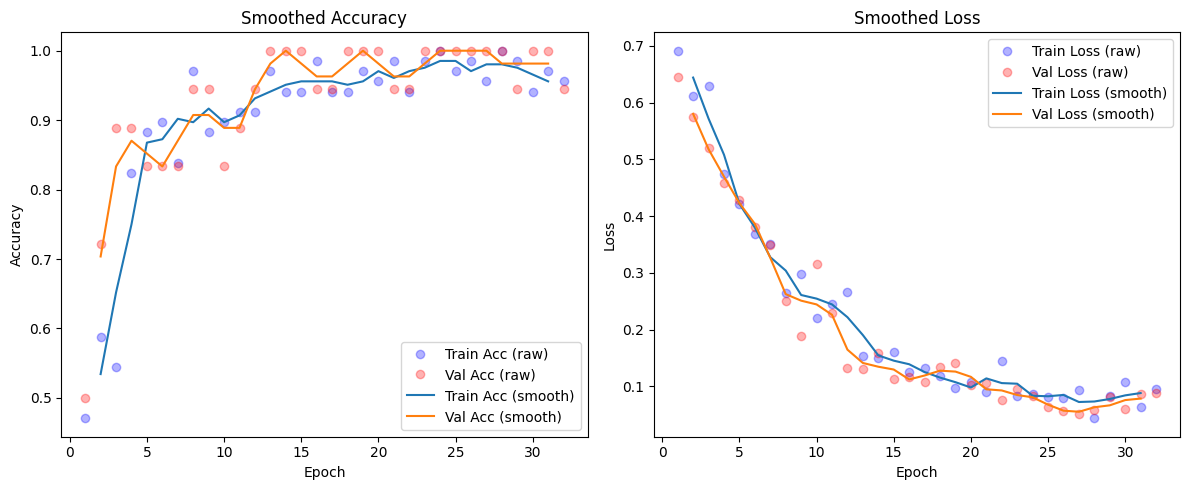

In [13]:
# --- Plotting Smoothed Metrics ---

def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Example with your training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Smoothed accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', alpha=0.3, label='Train Acc (raw)')
plt.plot(epochs, val_acc, 'ro', alpha=0.3, label='Val Acc (raw)')
plt.plot(epochs[1:-1], moving_average(acc), label='Train Acc (smooth)')
plt.plot(epochs[1:-1], moving_average(val_acc), label='Val Acc (smooth)')
plt.title('Smoothed Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Smoothed loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', alpha=0.3, label='Train Loss (raw)')
plt.plot(epochs, val_loss, 'ro', alpha=0.3, label='Val Loss (raw)')
plt.plot(epochs[1:-1], moving_average(loss), label='Train Loss (smooth)')
plt.plot(epochs[1:-1], moving_average(val_loss), label='Val Loss (smooth)')
plt.title('Smoothed Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

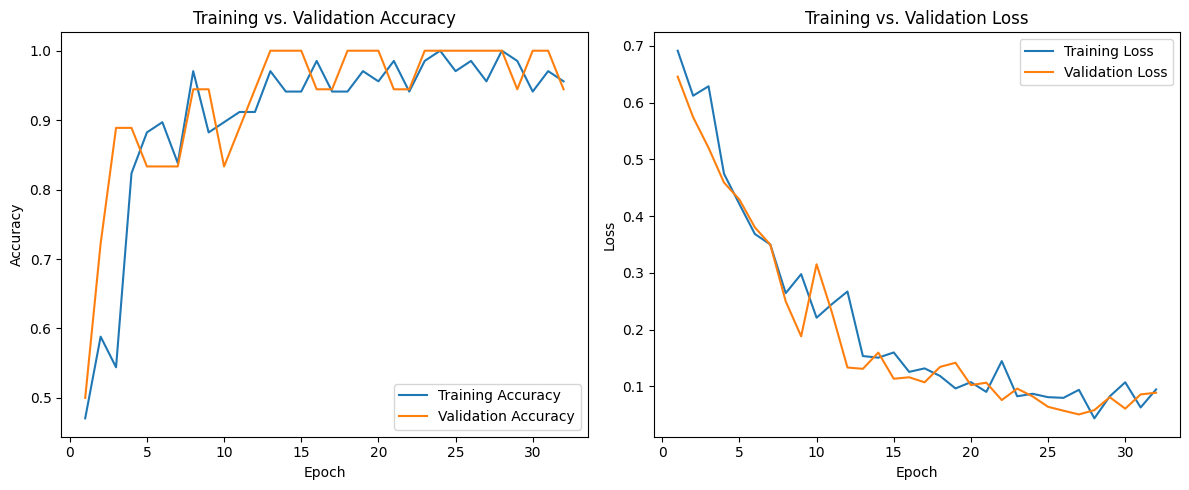

In [14]:


# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


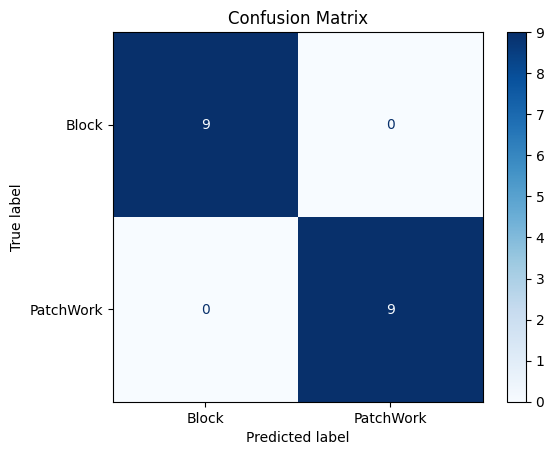

In [15]:
# --- Confusion Matrix ---
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


In [ ]:
model.save('SDCNN_BC_model.h5')  # Save the trained model